<a href="https://colab.research.google.com/github/hellomstars/DeepLearning/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN을 사용한 시퀀스 처리 
- Time series 예측

In [1]:
# 필요한 모듈 임포트트
import sklearn
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os
from pathlib import Path

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 기본적인 RNN

### 데이터셋 생성

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   사인곡선 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + 사인곡선 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + 잡음
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

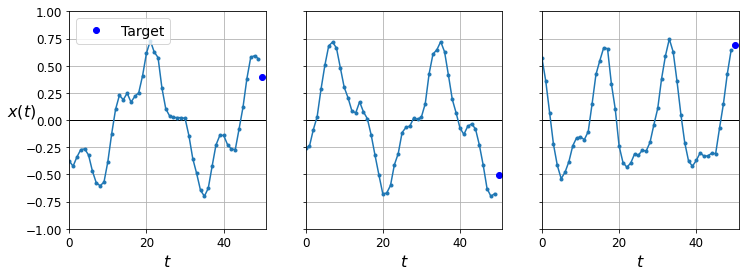

In [5]:
# 타킷 그래프 출력
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))

plt.show()

### 기준 성능 계산하기

In [6]:
# 단순 예측(Naive forecasting) : 마지막 값을 그대로 사용해 예측 
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

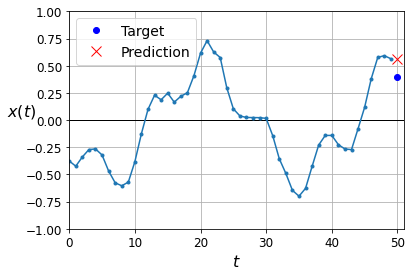

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [8]:
# 선형 예측(Linear regression)
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

# MSE loss, Adam optimizer 사용하여 epochs 20번 실행 
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 3ms/step - loss: 0.1127 - val_loss: 0.0279
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0176 - val_loss: 0.0140
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0123 - val_loss: 0.0118
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0109 - val_loss: 0.0105
Epoch 5/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0097 - val_loss: 0.0093
Epoch 6/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 7/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0078 - val_loss: 0.0073
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 9/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0063 - val_loss: 0.0059
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0058 - val_loss: 0.0054

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0037


0.0036768908612430096

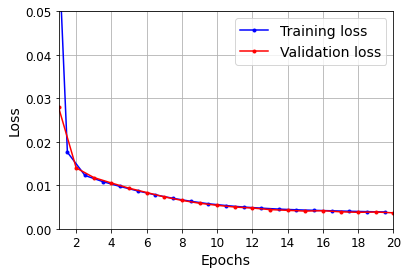

In [10]:
# 훈련한 모델의 loss 값 그래프 출력 
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 1ms/step


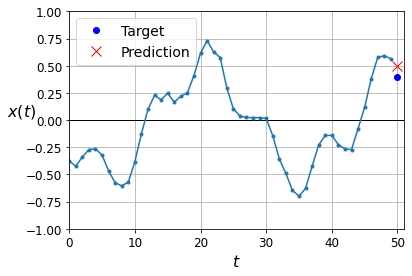

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Simple RNN

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

# Ssequence 길이를 지정하지 않아 none 입력
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 12s 50ms/step - loss: 0.0979 - val_loss: 0.0476
Epoch 2/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0363 - val_loss: 0.0292
Epoch 3/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0251 - val_loss: 0.0216
Epoch 4/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0197 - val_loss: 0.0176
Epoch 5/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0165 - val_loss: 0.0150
Epoch 6/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0145 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 8s 39ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0116 - val_l

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0109


0.010882214643061161

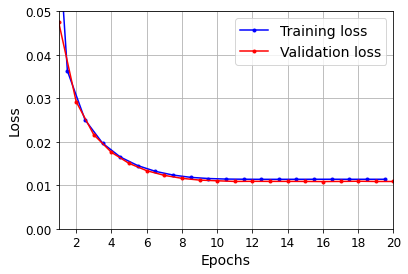

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 5ms/step


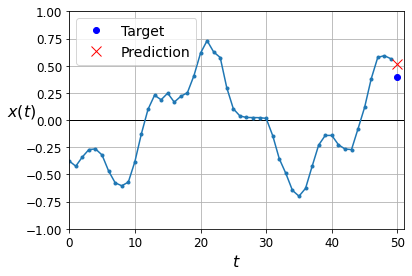

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNN

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 33s 138ms/step - loss: 0.0236 - val_loss: 0.0046
Epoch 2/20
219/219 [==============================] - 30s 138ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 3/20
219/219 [==============================] - 30s 139ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 4/20
219/219 [==============================] - 24s 111ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 5/20
219/219 [==============================] - 26s 117ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/20
219/219 [==============================] - 30s 137ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 25s 114ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/20
219/219 [==============================] - 24s 111ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 9/20
219/219 [==============================] - 25s 112ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 25s 115ms/step - l

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 12ms/step - loss: 0.0027


0.0026966349687427282

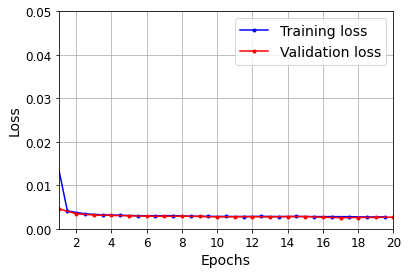

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 12ms/step


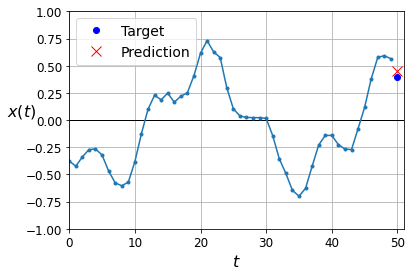

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [38]:
# 마지막 output에 RNN 대신 Dense layer 활용한 경우 - 불필요한 hidden state 감소로 빠르게 수렴해 성능 좋아짐 
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 29s 121ms/step - loss: 0.0665 - val_loss: 0.0366
Epoch 2/20
219/219 [==============================] - 25s 115ms/step - loss: 0.0324 - val_loss: 0.0287
Epoch 3/20
219/219 [==============================] - 17s 79ms/step - loss: 0.0276 - val_loss: 0.0338
Epoch 4/20
219/219 [==============================] - 22s 102ms/step - loss: 0.0245 - val_loss: 0.0228
Epoch 5/20
219/219 [==============================] - 17s 78ms/step - loss: 0.0240 - val_loss: 0.0219
Epoch 6/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0225 - val_loss: 0.0262
Epoch 7/20
219/219 [==============================] - 24s 109ms/step - loss: 0.0223 - val_loss: 0.0224
Epoch 8/20
219/219 [==============================] - 24s 108ms/step - loss: 0.0227 - val_loss: 0.0225
Epoch 9/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0216 - val_loss: 0.0224
Epoch 10/20
219/219 [==============================] - 22s 102ms/step - loss:

In [39]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0204


0.020407192409038544

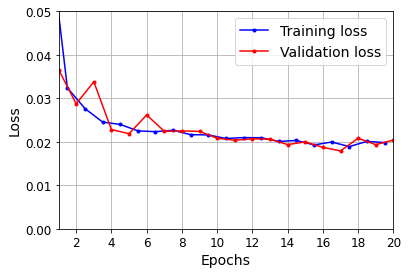

In [40]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 9ms/step


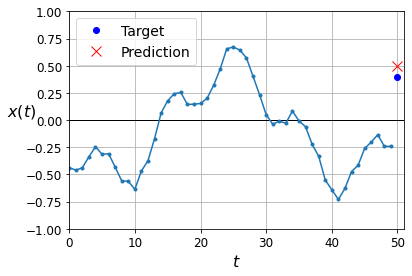

In [41]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 여러 time step에 대한 forecasting

### 순차적인 예측

In [20]:
np.random.seed(43) # 42는 훈련 세트에 있는 첫 번째 시리즈를 반환하기 때문에 다른 값으로 지정합니다

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]
Y_pred.shape

1/1 [==============================] - 0s 27ms/step


(1, 10, 1)

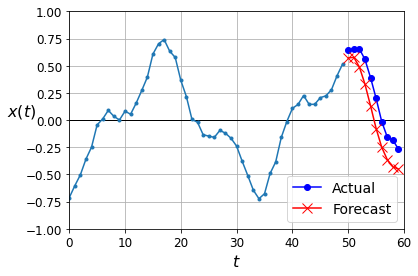

In [21]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### Vector 형식으로 예측 

In [22]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [23]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 1s 14ms/step


In [24]:
print(Y_pred.shape)
print(np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred)))

(2000, 10)
0.024771001


In [25]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # 마지막 타임 스텝 값을 선택해 10번 반복합니다
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 19s 76ms/step - loss: 0.0567 - val_loss: 0.0293
Epoch 2/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0240 - val_loss: 0.0173
Epoch 3/20
219/219 [==============================] - 16s 73ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0130 - val_loss: 0.0118
Epoch 5/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0115 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 18s 84ms/step - loss: 0.0105 - val_loss: 0.0089
Epoch 7/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0097 - val_loss: 0.0093
Epoch 8/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0097 - val_loss: 0.0081
Epoch 9/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0094 - val_loss: 0.0105
Epoch 10/20
219/219 [==============================] - 16s 74ms/step - loss: 0.008

In [27]:
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 210ms/step


### Sequence 형식으로 예측 

In [28]:
# 타임 스텝마다 다음 10 스텝을 예측하는 RNN
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

# 각 타깃은 10D 벡터의 시퀀스
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [29]:
# TimeDistributed wrapper 활용용
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [30]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 18s 75ms/step - loss: 0.0502 - last_time_step_mse: 0.0403 - val_loss: 0.0415 - val_last_time_step_mse: 0.0305
Epoch 2/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0368 - last_time_step_mse: 0.0250 - val_loss: 0.0317 - val_last_time_step_mse: 0.0204
Epoch 3/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0304 - last_time_step_mse: 0.0191 - val_loss: 0.0295 - val_last_time_step_mse: 0.0186
Epoch 4/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0284 - last_time_step_mse: 0.0168 - val_loss: 0.0257 - val_last_time_step_mse: 0.0137
Epoch 5/20
219/219 [==============================] - 17s 76ms/step - loss: 0.0261 - last_time_step_mse: 0.0141 - val_loss: 0.0247 - val_last_time_step_mse: 0.0130
Epoch 6/20
219/219 [==============================] - 16s 73ms/step - loss: 0.0247 - last_time_step_mse: 0.0124 - val_loss: 0.0251 - val_last_time_step_mse: 0.0133
Epoch 7/20
219/2

- Long sequence

## Layer normalization

In [31]:
# Input과 state에 대한 linear combination 계산 후 적용함
# Batch와 무관한 계산으로 샘플데이터에 대한 특성 통계가 필요없음
# training과 test에서 동일한 방식으로 동작 
from tensorflow import keras
from tensorflow.keras.layers import LayerNormalization

In [32]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 42s 166ms/step - loss: 0.1318 - last_time_step_mse: 0.1138 - val_loss: 0.0632 - val_last_time_step_mse: 0.0521
Epoch 2/20
219/219 [==============================] - 35s 160ms/step - loss: 0.0591 - last_time_step_mse: 0.0488 - val_loss: 0.0563 - val_last_time_step_mse: 0.0466
Epoch 3/20
219/219 [==============================] - 36s 165ms/step - loss: 0.0545 - last_time_step_mse: 0.0448 - val_loss: 0.0519 - val_last_time_step_mse: 0.0417
Epoch 4/20
219/219 [==============================] - 38s 174ms/step - loss: 0.0497 - last_time_step_mse: 0.0398 - val_loss: 0.0473 - val_last_time_step_mse: 0.0383
Epoch 5/20
219/219 [==============================] - 36s 162ms/step - loss: 0.0445 - last_time_step_mse: 0.0342 - val_loss: 0.0427 - val_last_time_step_mse: 0.0337
Epoch 6/20
219/219 [==============================] - 36s 164ms/step - loss: 0.0408 - last_time_step_mse: 0.0302 - val_loss: 0.0392 - val_last_time_step_mse: 0.0291
Epoch 7/20

## LSTM

In [34]:
# Long Short-Term Memory
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 12ms/step - loss: 0.0775 - last_time_step_mse: 0.0624 - val_loss: 0.0523 - val_last_time_step_mse: 0.0301
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0458 - last_time_step_mse: 0.0241 - val_loss: 0.0403 - val_last_time_step_mse: 0.0177
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0375 - last_time_step_mse: 0.0165 - val_loss: 0.0357 - val_last_time_step_mse: 0.0150
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0345 - last_time_step_mse: 0.0152 - val_loss: 0.0332 - val_last_time_step_mse: 0.0140
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0325 - last_time_step_mse: 0.0143 - val_loss: 0.0319 - val_last_time_step_mse: 0.0139
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0311 - last_time_step_mse: 0.0136 - val_loss: 0.0304 - val_last_time_step_mse: 0.0132
Epoch 7/20
219/219 [=======

In [35]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0229 - last_time_step_mse: 0.0078


[0.022926831617951393, 0.007782985456287861]

## 1D convolution layer (Non-causal)

In [36]:
# Stride를 이용하여 down sampling 효과
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 10s 11ms/step - loss: 0.0695 - last_time_step_mse: 0.0618 - val_loss: 0.0471 - val_last_time_step_mse: 0.0393
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0393 - last_time_step_mse: 0.0318 - val_loss: 0.0348 - val_last_time_step_mse: 0.0261
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0320 - last_time_step_mse: 0.0227 - val_loss: 0.0296 - val_last_time_step_mse: 0.0195
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0281 - last_time_step_mse: 0.0175 - val_loss: 0.0270 - val_last_time_step_mse: 0.0166
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0260 - last_time_step_mse: 0.0151 - val_loss: 0.0254 - val_last_time_step_mse: 0.0148
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0245 - last_time_step_mse: 0.0133 - val_loss: 0.0237 - val_last_time_step_mse: 0.0124
Epoch 7/20
219/219 [======

## WaveNet (causal convolution)

In [37]:
# Dilated convolution으로 매우 긴 receptive field를 효율적으로 구현 가능 
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 9ms/step - loss: 0.0653 - last_time_step_mse: 0.0532 - val_loss: 0.0374 - val_last_time_step_mse: 0.0224
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0339 - last_time_step_mse: 0.0203 - val_loss: 0.0307 - val_last_time_step_mse: 0.0172
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0292 - last_time_step_mse: 0.0164 - val_loss: 0.0277 - val_last_time_step_mse: 0.0150
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0268 - last_time_step_mse: 0.0143 - val_loss: 0.0260 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0254 - last_time_step_mse: 0.0131 - val_loss: 0.0249 - val_last_time_step_mse: 0.0123
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0244 - last_time_step_mse: 0.0121 - val_loss: 0.0238 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [========